# A\* vs IDA\*

En este ejercicio de programación compararás los recursos consumidos el algoritmo A* con los recursos consumidos por IDA*.

Ilustraremos la diferencia con el rompecabezas del 15.

In [1]:
from abc import ABC, abstractmethod

class EstadoProblema:
    """
    La clase EstadoProblema es abstracta.
    Representa un estado o configuración del problema a resolver.
    
    Es una interfaz simplificada para utilizarse
    en los algoritmos de búsqueda del curso.
    
    Al definir un problema particular hay que implementar los métodos
    abstractos
    """
    
    @abstractmethod
    def expand():
        """
        :return: el conjunto de estados sucesores
        """
        pass
    
    @abstractmethod
    def get_depth():
        """
        :return: la profundidad del estado
        """
        pass
        
    @abstractmethod
    def get_parent():
        """
        :return: referencia al estado predecesor o padre
        """
        pass
    

In [2]:
from functools import reduce
import random    

# La secuencia del 0 al 15
# 0 representará el espacio en blanco
seq = list(range(0,16))

# Cuatro posibles acciones para nuestro agente
# Mover una ficha en dirección: 
# izquierda (E), derecha (W), arriba (N), o abajo (S)
actions = ['E','W','N','S']

# Representaremos las configuraciones con bits
# Definimos algunas funciones útiles
# Recorre un bloque de 4 bits de unos a la posición i
x_mask = lambda i: 15<<(4*i)

# Extrae los cuatro bits que están en la posción i
# en la configuración c
# El rompecabezas tiene 16 posiciones (16X4 = 64 bits)
extract = lambda i,c: (c&(x_mask(i)))>>(4*i)

# Verifica si la posición z es la última columna
e_most = lambda z: (z%4)==3

# Verifica si la posición z es la primera columna
w_most = lambda z: (z%4)==0

# Verifica si la posición z es el primer renglón
n_most = lambda z: z<=3

# Verifica si la posición z es el último renglón
s_most = lambda z:z>=12

# Establecemos un diccionario con las acciones posibles
# para cada posición del rompecabezas
valid_moves = {i:list(filter(lambda action:\
((not action=='E') or (not e_most(i))) and \
((not action=='W') or (not w_most(i))) and \
((not action=='S') or (not s_most(i))) and \
((not action=='N') or (not n_most(i))),actions)) for i in seq}

# Realiza el movimiento hacía la izquierda
def move_east(puzzle):
    """
    :param puzzle: el rompecabezas
    """
    if(not e_most(puzzle.zero)):
        puzzle.zero += 1;
        mask = x_mask(puzzle.zero)
        puzzle.configuration = \
        (puzzle.configuration&mask)>>4 | \
        (puzzle.configuration&~mask)

# Realiza el movimiento hacía la derecha
def move_west(puzzle):
    if(not w_most(puzzle.zero)):
        puzzle.zero -= 1;
        mask = x_mask(puzzle.zero)
        puzzle.configuration = \
        (puzzle.configuration&mask)<<4 | \
        (puzzle.configuration&~mask)

# Realiza el movimiento hacía arriba
def move_north(puzzle):
    if(not n_most(puzzle.zero)):
        puzzle.zero -= 4;
        mask = x_mask(puzzle.zero)
        puzzle.configuration = \
        (puzzle.configuration&mask)<<16 | \
        (puzzle.configuration&~mask)

# Realiza el movimiento hacía abajo
def move_south(puzzle):
    if(not s_most(puzzle.zero)):
        puzzle.zero += 4;
        mask = x_mask(puzzle.zero)
        puzzle.configuration = \
        (puzzle.configuration&mask)>>16 | \
        (puzzle.configuration&~mask)

class Puzzle(EstadoProblema):
    """
    Rompecabezas del 15
    """
    
    
    def __init__(self, parent=None, action =None, depth=0):
        """
        Puede crearse un rompecabezas ordenado al no especificar
        parámetros del constructor.
        También se puede crear una nueva configuración a 
        partir de una configuración dada en parent.
        :param parent: configuración de referencia.
        :param action: la acción que se aplica a parent para
        generar la configuración sucesora.
        :depth la profundidad del estado a crear
        """
        self.parent = parent
        self.depth = depth
        if(parent == None):
            self.configuration =  \
                reduce(lambda x,y: x | (y << 4*(y-1)), seq)
            # posición del cero
            self.zero = 15
        else:
            self.configuration = parent.configuration
            self.zero = parent.zero
            if(action != None):
                self.move(action)

    def __str__(self):
        """
        :return: un string que representa 
        la configuración del rompecabezas
        """
        return '\n'+''.join(list(map(lambda i:\
        format(extract(i,self.configuration)," x")+\
        ('\n' if (i+1)%4==0 else ''),seq)))+'\n'

    def __repr__(self):
        """
        :return: representación texto de la configuración
        """
        return self.__str__()

    def __eq__(self,other):
        """
        :param other: la otra configuración con la que se comparará
        el objeto
        :return: verdadero cuando el objeto y el parámetro
        tienen la misma configuración.
        """
        return (isinstance(other, self.__class__)) and \
        (self.configuration==other.configuration)

    def __ne__(self,other):
        """
        :param other: la otra configuración con la que se comparará
        el objeto
        :return: verdadero cuando el objeto y el parámetro
        no tienen la misma configuración
        """
        return not self.__eq__(other)
        
    def __lt__(self,other):
        """
        :param other: la otra configuración con la que se comparará
        el objeto
        :return: verdadero cuando la profundidad del objeto
        es menor que la del argumento
        """
        return self.depth < other.depth

    def __hash__(self):
        """
        :return: un número hash para poder usar la configuración en 
        un diccionario, delegamos al hash de un entero
        """
        return hash(self.configuration)

    def move(self,action):
        """
        Realiza un movimiento de ficha.
        Debemos imaginar que el espacio se mueve en la dirección
        especificada por acción
        :param action: la acción a realizar
        """
        if(action =='E'):
            move_east(self)
        if(action =='W'):
            move_west(self)
        if(action =='N'):
            move_north(self)
        if(action =='S'):
            move_south(self)
        return self


    @staticmethod
    def to_list(puzzle):
        """
        Convertimos la configuración a una lista de números
        :param puzzle: la configuración a convertir
        :return la lista con enteros
        """
        return [extract(i,puzzle.configuration) for i in seq]

    def shuffle(self,n):
        """
        Desordena de manera aleatoria el rompecabezas.
        :param n: el número de movimientos aleatorios a aplicar
        """
        for i in range(0,n):
            self.move(random.choice(valid_moves[self.zero]))
        return self

    def expand(self):
        """
        Los sucesores del estado, quitamos el estado padre
        """
        #filtering the path back to parent
        return list(filter(lambda x: \
        (x!=self.parent), \
        [Puzzle(self,action,self.depth+1) \
        for action in valid_moves[self.zero]]))
    
    def get_depth(self):
        """
        :return: la profundidad del estado
        """
        return self.depth
    
    def get_parent(self):
        """
        :return: el nodo predecesor (padre) del estado 
        """
        return self.parent

In [3]:
# La secuencia del 0 al 15
# 0 representará el espacio en blanco
seq = list(range(0,16))
# el renglón
row = lambda i: i//4
# la columna
col = lambda i: i%4

class ManhattanDistance:
    """
    Implementación de la distancia de Manhattan para el rompecabezas del 15
    """
    def __init__(self,target = Puzzle()):
        """
        Crea el objeto para la meta establecida
        :param target: configuración meta
        """
        self.target =target
        self.locations =self._find_locations(target)
        self.distances = self._precompute_distances(self.locations)
        
    def _find_locations(self,puzzle):
        """
        Encuentra la posición de cada ficha
        :param puzzle: el rompecabezas
        :return: las posiciones
        """
        locations = [None]*16
        for i in enumerate(Puzzle.to_list(puzzle)):
            locations[i[1]] = i[0]
        return locations
        
    def _precompute_distances(self,locations):
        """
        Precalcula distancias por posición
        :param locations: ubicación de las fichas
        :return: las distancias
        """
        distances = [[0]*16 for i in seq]
        for i in seq:
            for j in seq:
                distances[i][j] = abs(row(j)-row(locations[i]))+ \
                abs(col(j)-col(locations[i]))
        return distances
       
    def distance_to_target(self,puzzle):
        """
        Calcula la distancia de Manhattan al objetivo
        :param puzzle: la configuración 
        :return: la distancia
        """
        # no consideramos la posición del cero
        return sum(map(lambda i:self.distances[i[0]+1][i[1]],\
        enumerate(self._find_locations(puzzle)[1:])))

## Algoritmo A\*

In [4]:
from collections import deque

# trajectory nos regresará la trayectoria a partir de un estado
def trajectory(end):
    # nos valemos de un deque para almacenar la ruta
    sequence = deque()
    # agregamos el estado final o meta
    sequence.append(end)
    # nos vamos regresando al estado predecesor mientras este exista
    while end.get_parent():
        # nos movemos al predecesor
        end = end.get_parent()
        # lo agregamos a la lista
        sequence.append(end)
    # invertimos el orden de la secuencia
    sequence.reverse()
    # lo regresamos como una lista
    return list(sequence)

Vamos a modificar el algoritmo A* para que nos entregue la historia de los nodos utilizados en la agenda y los nodos expandidos.

In [5]:
import heapq

class AStar:
    """
    Implementación del algoritmo A*
    """
    @staticmethod
    def search(origen,stop,g,h):
        """
        Búsqueda informada A*
        :param origen: estado inicial
        :param stop: función de paro, verdadera para el estado meta
        :param g: función de costo acumulado
        :param h: función heurística, costo estimado a la meta
        """
        # La historia de tamaño de la agenda y nodos expandidos
        historia = [(0,0)]
        # Nuestra cola de prioridad
        agenda = []
        # Conjunto de estados expandidos
        expandidos = set()
        # Condición trivial
        if stop(origen):
            # No se requirieron nodos en las estructuras de datos
            return (trajectory(origen),historia)
        
        # Estado inicial a la cola de prioridad
        # La prioridad será f(s) = g(s) + h(s), 
        # para s una configuración
        f = lambda s: g(s) + h(s)
        
        # Agregamos el origen a la agenda
        heapq.heappush(agenda,(f(origen),origen))
        
        # Mientras la agenda no este vacía
        while agenda:
            # agregamos los tamaños a la historia
            historia.append((len(agenda),len(expandidos)))
            # El frente de la cola de prioridad es la configuración
            # de menor costo f
            nodo = heapq.heappop(agenda)[1]
            # Agregamos el estado a la lista de expandidos
            expandidos.add(nodo)
            # En A* es necesario verificar la condición de 
            # paro tras sacar el elemento de la agenda
            if stop(nodo):
                return (trajectory(nodo),historia)
            # Realizamos la expansión del vértice
            for sucesor in nodo.expand():
                # Agregamos a la cola de prioridad siempre que no se haya
                # expandido previamente
                if sucesor not in expandidos:
                    heapq.heappush(agenda,(f(sucesor),sucesor))
        # No hay ruta al nodo meta
        # instrucción redundante
        return None

In [6]:
from random import seed
# inicializamos el generador de números aleatorios
seed(2019)
p = Puzzle()
# 40 movimientos aleatorios
p.shuffle(100)
print("rompecabezas a resolver:",p)

rompecabezas a resolver: 
 1 3 e 4
 b 0 2 8
 5 9 7 c
 6 a d f




In [7]:
m = ManhattanDistance()
ruta,historia = AStar.search(p,
                             lambda s:s==Puzzle(),
                             lambda s:s.get_depth(),
                             lambda s:m.distance_to_target(s))
print("longitud de la ruta",len(ruta)-1)
print("iteraciones:",len(historia))

longitud de la ruta 26
iteraciones: 2192


Vamos a definir una función para graficar el consumo de memoria

In [8]:
import matplotlib.pyplot as plt

# definimos una función para graficar el consumo de recursos del algoritmo
def dibujar_grafica(historia,algoritmo):
    
    n_agenda, n_expandidos = zip(*historia)
    n_total =  [a+b for a,b in historia]
    a,=plt.plot(n_agenda,'blue')
    b,=plt.plot(n_expandidos,'red')
    c,=plt.plot(n_total,'green')
    plt.legend([a,b,c],['agenda','expandidos','total'])
    plt.xlabel('iteración')
    plt.ylabel('estados')
    plt.title('Memoria consumida por '+algoritmo)
    plt.show()

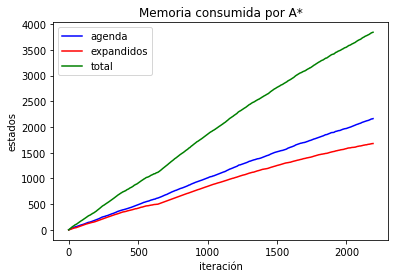

In [9]:
#invocamos la función dibujar_grafica para A*
dibujar_grafica(historia,'A*')

## Algoritmo IDA\*

Ahora presentamos un esqueleto de código para la versión iterativa del algoritmo IDA*.

Tienes que completarlo para tu tarea de programación.

In [18]:
from collections import deque
import math

class IDAStar:
    
    @staticmethod
    def search(start,stop,g,h):
        """
        Búsqueda A* con profundidad iterada, versión iterativa
        :param start: estado inicial
        :param stop: función de paro
        :param g: función de costo acumulado
        :param h: función heurística, estimación de costo a la meta
        """
        historia = [(0,0)]
        if stop(start):
            # regresamos la ruta, no se asignó memoria adicional
            return (trajectory(start),[(0,0)])
        
        # c es la cota de costo, se asigna a la heurística del nodo inicial
        c = h(start)
        # definimos la función f
        f = lambda x:g(x) + h(x)
        
        # repetimos un número de iteraciones indeterminado
        while True:
            # el mínimo es infinito
            minimo = math.inf
            
            # usaremos una cola de prioridad como agenda
            agenda = deque()
    
            # agregamos el estado inicial a la agenda
            agenda.append(start)
            
            # el conjunto de expandidos
            x = set()
            
            while agenda:
                
                historia.append((len(agenda),len(x)))

                # la agenda es una pila
                # observamos el elemento en el tope
                # PERO NO LO SACAMOS (Muy importante)
                n = agenda[-1]
                
                # siempre que no se haya expandido previamente
                # en la historia de la ruta que esta en x
                if n not in x:
                    # agregamos el nodo a la ruta
                    x.add(n)
                    
                    # obtenemos los sucesores del nodo
                    sucesores = n.expand()
                    # los ordenamos por su valor de f de menor a mayor
                    sucesores.sort(key = lambda x:f(x),reverse=False)

                    # para cada sucesor
                    for s in sucesores:
                        # verificamos la meta
                        if stop(s):
                            return (trajectory(s),historia)
                        # actualiza la agenda tomando en cuenta la cota c
                        # si es necesario actualiza el valor del mínimo
                        # INSERTA TU CÓDIGO AQUÍ
                        else: 
                            if f(s) <= c:
                                if s not in x:
                                    agenda.append(s)
                            else:
                                if f(s) < minimo:
                                    minimo = f(s)
                        
                # n ya esta en la ruta
                else:
                    # lo sacamos de la agenda
                    agenda.pop()
                    # lo removemos de la ruta
                    x.remove(n)
            # La agenda está vacía
            # actualizamos la cota de la siguiente iteración con el mínimo
            c = minimo
            # si el mínimo es infinito
            if c == math.inf:
                # No hay ruta a la meta
                return (None,historia)

In [19]:
# Descomenta y ejecuta las lineas siguientes
ruta,historia = IDAStar.search(p,
                             lambda s:s==Puzzle(),
                             lambda s:s.get_depth(),
                             lambda s:m.distance_to_target(s))
print("longitud de la ruta",len(ruta)-1)
print("iteraciones:",len(historia))

longitud de la ruta 26
iteraciones: 6803


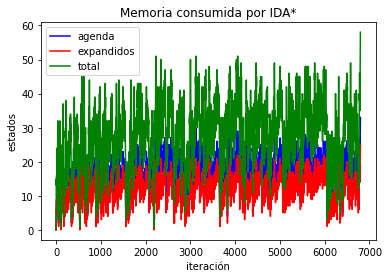

In [20]:
# descomenta la última línea para generar la gráfica
# invocamos la función dibujar gráfica para el algoritmo IDA*
dibujar_grafica(historia,'IDA*')

Debes poder concluir de las gráficas anteriores que IDA* consume menos memoria, aunque requiere mayor número de iteraciones.

In [22]:
# Descomenta y corre la siguientes líneas, 
# copia la salida en un archivo y somételo como tarea
#respuesta = "".join(str(a)+str(x) for a,x in historia)+"".join(str(c.configuration) for c in ruta)
respuesta = "".join(str(a)+str(x) for a,x in historia)
print(respuesta)

0010314263645374959685969786756475961071181391310129131013111210119108978697108119121013111512171317141613171417151614151314121413131212111110109988776655443322142433243547586107108971181391310129131013111210119108119121013111512171317141613171417151614151314121413131212111110109988776657677665544332211105162838473848574635241526384857495106117128129118107968596117118107128149141013914101411131012911812913101411151216131814201520161915201620171916181517141715161415131412131112101191089786756453423152534263748596978675645384857495106107968510610796107108978675649510611713814915101711171216111712171316121511141013912813914101511161217131914211521162015211621172016191518141815171416131512141113101291181079685867510610796127138139128117118107138139128139131012911813914101411131012914101411131014111412131112101191089786107108971181191081391410161116121511161216131512141113101291210119141014111310131112101511161216131512141114121311161217131714161315121713181418151714161318141815171418151816